In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import Statevector,Operator,SparsePauliOp
from qiskit.primitives import StatevectorSampler,StatevectorEstimator
from scipy.optimize import minimize
import numpy as np

First we show that for any ansatz, we can start from two different computational basis and applying the ansatz still holds the orthogonality.

Starting from different computational basis by applying x gate in the first qubit.

Now examining the overlap of both the output states

Now Lets check the performance for VQE. We find the first eigenstate and store the theta values. Then we check with respect to different computational basis states.

First we generate a hermitian operator over which the VQE will run

In [55]:
qubits=5
import numpy as np

import numpy as np

import numpy as np

def generate_covariance_band_decay_matrix(n, bandwidth, decay_rate):
    """
    Generate a real symmetric positive semidefinite (PSD) covariance matrix
    with decaying values away from the diagonal.

    Parameters:
        n (int): Size of the matrix (n x n).
        bandwidth (int): Controls effective band width (must be > 0).
        decay_rate (float): Exponential decay factor.

    Returns:
        np.ndarray: Covariance matrix (real symmetric PSD).
    """
    if bandwidth <= 0:
        raise ValueError("Bandwidth must be positive.")

    A = np.zeros((n, n))

    for i in range(n):
        for j in range(n):  # no need to restrict to upper triangle
            distance = abs(i - j)
            decay = np.exp(-decay_rate * (distance / bandwidth) ** 2)
            A[i, j] = decay * np.random.rand()

    # Make it PSD
    C = A @ A.T

    # Optional: ensure numerical PSD
    eigvals, eigvecs = np.linalg.eigh(C)
    eigvals_clipped = np.clip(eigvals, 0, None)
    C = eigvecs @ np.diag(eigvals_clipped) @ eigvecs.T

    return C



hermitian_matrix =generate_covariance_band_decay_matrix(n=2**qubits, bandwidth=2, decay_rate=3.0)
print(f"Hermitian Matrix:{hermitian_matrix}")
z=Operator(-hermitian_matrix)
Pauli=SparsePauliOp.from_operator(z)
print(Pauli)


Hermitian Matrix:[[ 8.84471079e-01  4.11008545e-01  7.54155191e-02 ...  4.30088820e-19
   2.73408271e-19  3.01497051e-20]
 [ 4.11008545e-01  5.32955874e-01  2.48468519e-01 ... -4.83759964e-19
  -2.65957726e-19 -3.40679065e-20]
 [ 7.54155191e-02  2.48468519e-01  1.83435117e-01 ... -4.16650054e-19
  -6.62003629e-19 -6.60571846e-20]
 ...
 [ 4.24816353e-19 -4.97299985e-19 -4.08114707e-19 ...  1.94130872e-01
   2.98992614e-01  2.56635517e-02]
 [ 2.78942476e-19 -2.75048863e-19 -6.67464774e-19 ...  2.98992614e-01
   1.16368709e+00  1.27128028e-01]
 [ 3.24658985e-20 -3.45337976e-20 -6.87195453e-20 ...  2.56635517e-02
   1.27128028e-01  5.85877674e-02]]
SparsePauliOp(['IIIII', 'IIIIX', 'IIIIZ', 'IIIXI', 'IIIXX', 'IIIXZ', 'IIIYY', 'IIIZI', 'IIIZX', 'IIIZZ', 'IIXII', 'IIXIX', 'IIXIZ', 'IIXXI', 'IIXXX', 'IIXXZ', 'IIXYY', 'IIXZI', 'IIXZX', 'IIYIY', 'IIYXY', 'IIYYI', 'IIYYX', 'IIYYZ', 'IIYZY', 'IIZII', 'IIZIX', 'IIZIZ', 'IIZXI', 'IIZXX', 'IIZXZ', 'IIZYY', 'IIZZI', 'IIZZX', 'IIZZZ', 'IXXII', 'IXXIX',

Now recall the ansatz we have used previously, but the parameters will be variables and will be optimized through StatevectorEstimator

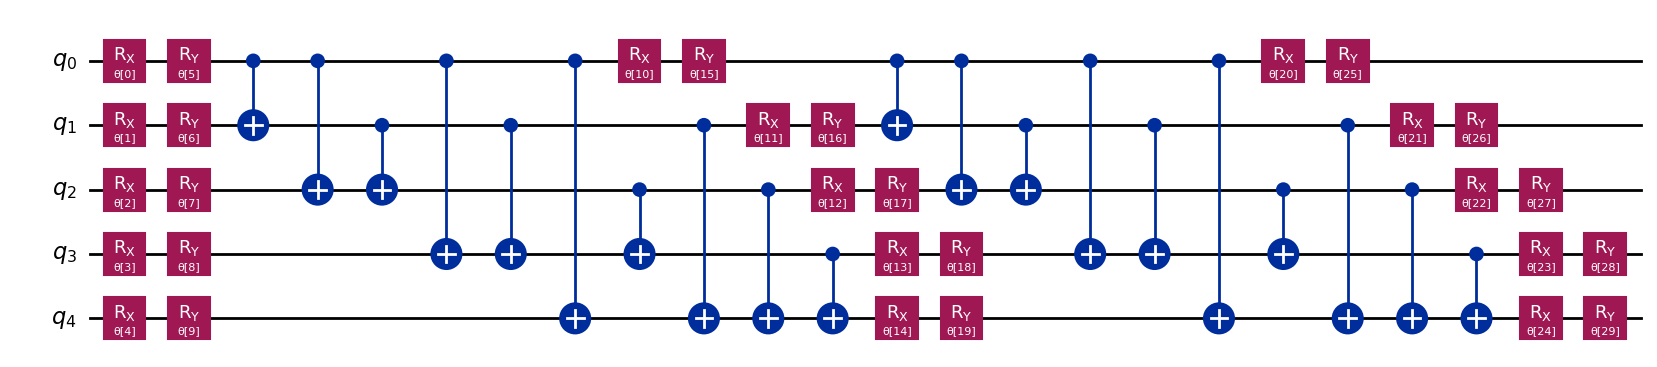

In [63]:
qc_ansatz_vqe=TwoLocal(qubits,rotation_blocks=["rx","ry"],entanglement="full",entanglement_blocks="cx",reps=2)
qc_vqe=QuantumCircuit(qubits)
qc_vqe=qc_vqe.compose(qc_ansatz_vqe)
theta=np.random.rand(qc_ansatz_vqe.num_parameters)
qc_vqe.decompose().draw("mpl")

Use Statevector Estimator primitve to calculate the energy and design the cost function

In [64]:
estimator=StatevectorEstimator()
def obj_fun(params,qc_fun,ham,estimator_pri):
    job=estimator_pri.run([(qc_fun,ham,[params])]).result()[0]
    return job.data.evs
z=minimize(obj_fun,theta,args=(qc_vqe,Pauli,estimator),method="BFGS")
print(f"Predicted VQE: {z['fun']}")
a=np.linalg.eig(hermitian_matrix)
print(f"True Value:{np.sort(np.real(a[0]))}")
#print(z)

Predicted VQE: -1.5293330977166908
True Value:[1.92072452e-04 7.19671635e-04 3.30429527e-03 9.38930856e-03
 1.68098671e-02 1.79267561e-02 3.38882964e-02 4.08378943e-02
 4.23428182e-02 5.00260347e-02 6.26743857e-02 8.52070601e-02
 9.21179982e-02 1.41400710e-01 1.42857482e-01 1.93287140e-01
 2.21247534e-01 2.57114881e-01 2.65754706e-01 3.32879205e-01
 4.06115770e-01 6.08332535e-01 6.30532793e-01 6.84801974e-01
 9.05508650e-01 1.03938262e+00 1.20547146e+00 1.28102955e+00
 1.29886329e+00 1.45928895e+00 1.53225969e+00 1.67755987e+00]


Now check for the obtained theta values with other computational basis states


True eigenvalues Value:[4.07756877e-07 3.15568751e-02 1.62329626e-01 6.57246709e-01]
[-0.65724671]
[-0.13539935]


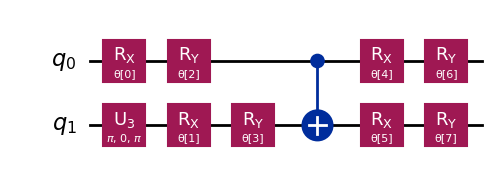

In [54]:
theta_opt=z["x"]
#print(theta_opt)
print(f"True eigenvalues Value:{np.sort(np.real(a[0]))}")
print(obj_fun(theta_opt,qc_vqe,Pauli,estimator))
qc_vqe_o1=QuantumCircuit(qubits)
qc_vqe_o1.x(1)
#qc_vqe_o1.x(0)
new_ansatz=TwoLocal(qubits,rotation_blocks=["rx","ry"],entanglement="linear",entanglement_blocks="cx",reps=1)
qc_vqe_o1=qc_vqe_o1.compose(new_ansatz)
print(obj_fun(theta_opt,qc_vqe_o1,Pauli,estimator))
qc_vqe_o1.decompose().draw("mpl")

In [10]:
Z1=Statevector(qc_vqe_o1.assign_parameters(theta_opt)).data
print(Z1)
#print(a)
Z2=Statevector(qc_vqe.assign_parameters(theta_opt)).data
print(Z2)
print(np.dot(np.conj(Z1),Z2))




[ 0.07277538-0.36751153j -0.11510073-0.24927865j  0.18365982-0.10089816j
  0.39452717-0.31071344j -0.1358709 +0.0164395j  -0.31434372-0.02971569j
 -0.38364078+0.06426892j -0.44195415+0.15193662j]
[ 0.39980559-0.33348547j  0.39674104-0.27098058j -0.26090525-0.08427049j
 -0.4341485 +0.07437798j  0.01433957+0.25302951j  0.17569539+0.26236506j
 -0.24680447+0.0364253j  -0.05186597+0.00746717j]
(-5.551115123125783e-17-1.3877787807814457e-16j)


In [11]:
# Compute the eigenvalues and eigenvectors of the Hermitian matrix
eigenvalues, eigenvectors = np.linalg.eigh(hermitian_matrix)

# Compute the projection of Z2 onto each eigenvector
projections = np.dot(eigenvectors.T.conj(), Z2)

# Compute the distances
distances = [np.linalg.norm(Z2 - proj * eigvec) for proj, eigvec in zip(projections, eigenvectors.T)]

# Find the minimum distance
min_distance = min(distances)
nearest_index = distances.index(min_distance)

# Print the results
print("Distances from each eigenvector:", distances)
print(f"Minimum distance: {min_distance}")
print(f"Closest eigenvector corresponds to eigenvalue: {eigenvalues[nearest_index]}")


Distances from each eigenvector: [np.float64(0.47068401967120793), np.float64(0.9144140629717264), np.float64(0.9891841090990804), np.float64(0.9984561138475595), np.float64(0.9966447294540628), np.float64(0.9971084616121074), np.float64(0.9897050843605315), np.float64(0.9999307511602336)]
Minimum distance: 0.47068401967120793
Closest eigenvector corresponds to eigenvalue: -1.3546680369959623


In [12]:
# Find an orthogonal vector to Z2 using Gram-Schmidt
random_vector = np.random.rand(*Z2.shape) + 1j * np.random.rand(*Z2.shape)  # Random complex vector
orthogonal_vector = random_vector - np.dot(np.conjugate(Z2), random_vector) * Z2
orthogonal_vector = orthogonal_vector / np.linalg.norm(orthogonal_vector)  # Normalize

print("Z2:", Z2)
print("Orthogonal vector to Z2:", orthogonal_vector)

# Compute eigenvalues and eigenvectors of the Hermitian matrix
eigenvalues, eigenvectors = np.linalg.eigh(hermitian_matrix)

# Compute projections for Z2
projections_Z2 = np.dot(eigenvectors.T.conj(), Z2)
distances_Z2 = [np.linalg.norm(Z2 - proj * eigvec) for proj, eigvec in zip(projections_Z2, eigenvectors.T)]

# Compute projections for the orthogonal vector
projections_orthogonal = np.dot(eigenvectors.T.conj(), orthogonal_vector)
distances_orthogonal = [np.linalg.norm(orthogonal_vector - proj * eigvec) for proj, eigvec in zip(projections_orthogonal, eigenvectors.T)]

# Find the minimum distance for each vector
min_distance_Z2 = min(distances_Z2)
nearest_index_Z2 = distances_Z2.index(min_distance_Z2)

min_distance_orthogonal = min(distances_orthogonal)
nearest_index_orthogonal = distances_orthogonal.index(min_distance_orthogonal)

# Print results
print("\n--- Z2 Analysis ---")
print("Distances from each eigenvector (Z2):", distances_Z2)
print(f"Minimum distance (Z2): {min_distance_Z2}")
print(f"Closest eigenvector (Z2) corresponds to eigenvalue: {eigenvalues[nearest_index_Z2]}")

print("\n--- Orthogonal Vector Analysis ---")
print("Distances from each eigenvector (Orthogonal Vector):", distances_orthogonal)
print(f"Minimum distance (Orthogonal Vector): {min_distance_orthogonal}")
print(f"Closest eigenvector (Orthogonal Vector) corresponds to eigenvalue: {eigenvalues[nearest_index_orthogonal]}")


Z2: [ 0.39980559-0.33348547j  0.39674104-0.27098058j -0.26090525-0.08427049j
 -0.4341485 +0.07437798j  0.01433957+0.25302951j  0.17569539+0.26236506j
 -0.24680447+0.0364253j  -0.05186597+0.00746717j]
Orthogonal vector to Z2: [ 0.29908117+0.08267177j  0.29885426+0.10841935j  0.18608394+0.29254854j
  0.30130749+0.1360679j   0.19917962+0.21512151j -0.02221677+0.21975113j
  0.3772493 +0.34402835j  0.371223  +0.19980406j]

--- Z2 Analysis ---
Distances from each eigenvector (Z2): [np.float64(0.47068401967120793), np.float64(0.9144140629717264), np.float64(0.9891841090990804), np.float64(0.9984561138475595), np.float64(0.9966447294540628), np.float64(0.9971084616121074), np.float64(0.9897050843605315), np.float64(0.9999307511602336)]
Minimum distance (Z2): 0.47068401967120793
Closest eigenvector (Z2) corresponds to eigenvalue: -1.3546680369959623

--- Orthogonal Vector Analysis ---
Distances from each eigenvector (Orthogonal Vector): [np.float64(0.9979995514111688), np.float64(0.998099288775